<a href="https://colab.research.google.com/github/smitasasindran/era4/blob/session5/Session5/ERA4_Session_5_Iteration4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Import libraries

In [45]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

2. Check GPU

In [46]:
cuda = torch.cuda.is_available()
print(f"CUDA Available: {cuda}")

random_seed = 21
torch.manual_seed(random_seed)
if cuda:
    torch.cuda.manual_seed(random_seed)

CUDA Available: True


3. Create transformations

In [47]:
# Train data transformations
train_transforms = transforms.Compose([
    transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    transforms.Resize((28, 28)),
    transforms.RandomRotation((-15., 15.), fill=0),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
])

# Test data transformations. Use same mean and std as train set
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.1407,), (0.4081,))
    transforms.Normalize((0.1307,), (0.3081,)),
])

4. Get train and test data

In [48]:
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)

5. Create data loaders

In [49]:
batch_size = 128
# batch_size=256
# kwargs = {'batch_size': batch_size, 'shuffle': False, 'num_workers': 2, 'pin_memory': True}
kwargs = {'batch_size': batch_size, 'shuffle': False, 'num_workers': 2, 'pin_memory': True}

train_loader = torch.utils.data.DataLoader(train_data, **kwargs)
test_loader = torch.utils.data.DataLoader(test_data, **kwargs)

6. Plot some data

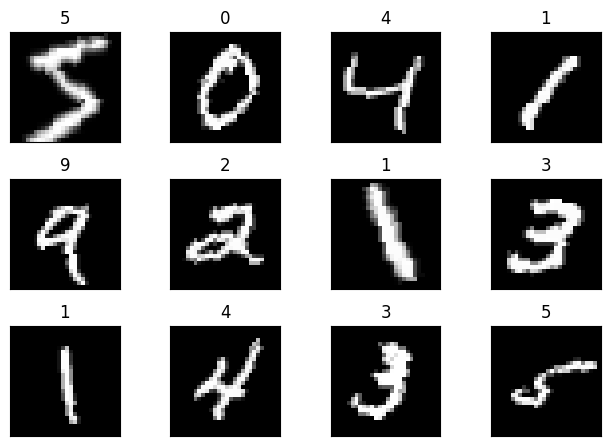

In [50]:
import matplotlib.pyplot as plt

batch_data, batch_label = next(iter(train_loader))

fig = plt.figure()

for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])


7. Create the model

In [51]:
# class Net(nn.Module):
#     # Define the structure of the NN

#     def __init__(self):
#         super(Net, self).__init__()
#         self.conv1 = nn.Conv2d(1, 8, kernel_size=3)
#         self.bn1 = nn.BatchNorm2d(num_features=8) # num_features should match previous layer out channels
#         self.conv2 = nn.Conv2d(8, 16, kernel_size=3)
#         self.bn2 = nn.BatchNorm2d(num_features=16)
#         self.conv3 = nn.Conv2d(16, 32, kernel_size=3)
#         self.dropout1 = nn.Dropout(p=0.05)
#         self.bn3 = nn.BatchNorm2d(num_features=32)
#         self.conv4 = nn.Conv2d(32, 8, kernel_size=1)
#         # -> maxpooling
#         self.conv5 = nn.Conv2d(8, 16, kernel_size=3)
#         self.bn5 = nn.BatchNorm2d(num_features=16)
#         self.conv6 = nn.Conv2d(16, 16, kernel_size=3)
#         self.bn6 = nn.BatchNorm2d(num_features=16)
#         self.fc1 = nn.Linear(784, 10)
#         self.dropout2 = nn.Dropout(p=0.05)

#     def forward(self, x):
#         # 1 x 1 should be before maxpooling, not after -- compress original features better
#         # relu after maxpooling, or relu before maxpooling have same output

#         x = F.relu(self.conv1(x), 2)    # 512 x 8 x 26 x 26
#         x = self.bn1(x)
#         x = F.relu(self.conv2(x), 2)    # 512 x 16 x 24 x 24
#         x = self.bn2(x)
#         x = F.relu(self.conv3(x))       # 512 x 32 x 22 x 22
#         x = self.bn3(x)
#         x = self.dropout1(x)
#         x = self.conv4(x)               # 512 x 8 x 22 x 22
#         x = F.relu(F.max_pool2d(x, 2))  # 512 x 8 x 11 x 11

#         x = F.relu(self.conv5(x))  # 512 x 16 x 9 x 9
#         x = self.bn5(x)
#         x = F.relu(self.conv6(x))  # 512 x 32 x 7 x 7
#         x = self.bn6(x)
#         x = x.view(-1, 784)
#         x = self.dropout2(x)
#         x = self.fc1(x)
#         return x


In [52]:
class Net(nn.Module):
    # Define the structure of the NN

    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(num_features=8) # num_features should match previous layer out channels
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(num_features=16)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3)
        self.dropout1 = nn.Dropout(p=0.05)
        self.bn3 = nn.BatchNorm2d(num_features=32)
        self.conv4 = nn.Conv2d(32, 8, kernel_size=1)
        # -> maxpooling
        self.conv5 = nn.Conv2d(8, 16, kernel_size=3)
        self.bn5 = nn.BatchNorm2d(num_features=16)
        self.conv6 = nn.Conv2d(16, 16, kernel_size=3)
        self.bn6 = nn.BatchNorm2d(num_features=16)
        self.fc1 = nn.Linear(784, 10)

    def forward(self, x):
        # 1 x 1 should be before maxpooling, not after -- compress original features better
        # relu after maxpooling, or relu before maxpooling have same output

        x = F.relu(self.conv1(x), 2)    # 512 x 8 x 26 x 26
        x = self.bn1(x)
        x = F.relu(self.conv2(x), 2)    # 512 x 16 x 24 x 24
        x = self.bn2(x)
        x = F.relu(self.conv3(x))       # 512 x 32 x 22 x 22
        x = self.bn3(x)
        # print(f"Before dropout1: {x.shape}")
        x = self.dropout1(x)
        x = self.conv4(x)               # 512 x 8 x 22 x 22
        # print(f"After conv4: {x.shape}")
        x = F.relu(F.max_pool2d(x, 2))  # 512 x 8 x 11 x 11

        x = F.relu(self.conv5(x))  # 512 x 16 x 9 x 9
        x = self.bn5(x)
        x = F.relu(self.conv6(x))  # 512 x 32 x 7 x 7
        x = self.bn6(x)
        x = x.view(-1, 784)
        x = self.fc1(x)
        return x


8. Model Summary

In [53]:
from torchsummary import summary

device = "cuda" if cuda else "cpu"
model = Net().to(device)

summary(model, input_size=(1, 28, 28))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              80
       BatchNorm2d-2            [-1, 8, 26, 26]              16
            Conv2d-3           [-1, 16, 24, 24]           1,168
       BatchNorm2d-4           [-1, 16, 24, 24]              32
            Conv2d-5           [-1, 32, 22, 22]           4,640
       BatchNorm2d-6           [-1, 32, 22, 22]              64
           Dropout-7           [-1, 32, 22, 22]               0
            Conv2d-8            [-1, 8, 22, 22]             264
            Conv2d-9             [-1, 16, 9, 9]           1,168
      BatchNorm2d-10             [-1, 16, 9, 9]              32
           Conv2d-11             [-1, 16, 7, 7]           2,320
      BatchNorm2d-12             [-1, 16, 7, 7]              32
           Linear-13                   [-1, 10]           7,850
Total params: 17,666
Trainable params: 

9. Initializing variables

In [54]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

10. Train and test functions

In [55]:
from tqdm import tqdm

def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer, criterion):
    model.train()
    pbar = tqdm(train_loader)

    train_loss = 0
    correct = 0
    processed = 0

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()

        # Predict
        pred = model(data)

        # Calculate loss
        # print(f"Prediction: {pred}, target={target}")
        loss = criterion(pred, target)
        train_loss += loss.item()

        # Backpropagation
        loss.backward()
        optimizer.step()

        correct += GetCorrectPredCount(pred, target)
        processed += len(data)

        pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

    train_acc.append(100 * correct / processed)
    train_losses.append(train_loss / len(train_loader))


def test(model, device, test_loader, criterion):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            # test_loss += criterion(output, target, reduction='sum').item() # Sum up batch loss
            test_loss += criterion(output, target).item() # Sum up batch loss

            correct += GetCorrectPredCount(output, target)

    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


11. Train the model

In [56]:
device = "cuda" if cuda else "cpu"
model = Net().to(device)
# optimizer = optim.Adam(model.parameters(), lr=0.01)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)

criterion = nn.CrossEntropyLoss(reduction='mean')
num_epochs = 20

for epoch in range(1, num_epochs+1):
    print(f"Epoch {epoch}")
    train(model, device, train_loader, optimizer, criterion)
    test(model, device, test_loader, criterion)
    scheduler.step()

Epoch 1


Train: Loss=0.1598 Batch_id=468 Accuracy=94.83: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:05<00:00, 85.91it/s]


Test set: Average loss: 0.0004, Accuracy: 9851/10000 (98.51%)

Epoch 2


Train: Loss=0.2243 Batch_id=468 Accuracy=98.02: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:05<00:00, 87.54it/s]


Test set: Average loss: 0.0003, Accuracy: 9886/10000 (98.86%)

Epoch 3


Train: Loss=0.2203 Batch_id=468 Accuracy=98.34: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:05<00:00, 87.61it/s]


Test set: Average loss: 0.0002, Accuracy: 9904/10000 (99.04%)

Epoch 4


Train: Loss=0.2139 Batch_id=468 Accuracy=98.58: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:05<00:00, 85.36it/s]


Test set: Average loss: 0.0002, Accuracy: 9903/10000 (99.03%)

Epoch 5


Train: Loss=0.2030 Batch_id=468 Accuracy=98.74: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:05<00:00, 86.44it/s]


Test set: Average loss: 0.0002, Accuracy: 9913/10000 (99.13%)

Epoch 6


Train: Loss=0.1995 Batch_id=468 Accuracy=98.78: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:05<00:00, 88.37it/s]


Test set: Average loss: 0.0002, Accuracy: 9919/10000 (99.19%)

Epoch 7


Train: Loss=0.1864 Batch_id=468 Accuracy=98.87: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:05<00:00, 88.24it/s]


Test set: Average loss: 0.0002, Accuracy: 9909/10000 (99.09%)

Epoch 8


Train: Loss=0.2215 Batch_id=468 Accuracy=98.93: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:05<00:00, 85.19it/s]


Test set: Average loss: 0.0002, Accuracy: 9916/10000 (99.16%)

Epoch 9


Train: Loss=0.1539 Batch_id=468 Accuracy=99.00: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:05<00:00, 83.52it/s]


Test set: Average loss: 0.0002, Accuracy: 9914/10000 (99.14%)

Epoch 10


Train: Loss=0.1625 Batch_id=468 Accuracy=99.06: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:05<00:00, 91.70it/s]


Test set: Average loss: 0.0002, Accuracy: 9925/10000 (99.25%)

Epoch 11


Train: Loss=0.1669 Batch_id=468 Accuracy=99.09: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:05<00:00, 90.00it/s]


Test set: Average loss: 0.0002, Accuracy: 9923/10000 (99.23%)

Epoch 12


Train: Loss=0.1708 Batch_id=468 Accuracy=99.11: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:05<00:00, 83.56it/s]


Test set: Average loss: 0.0002, Accuracy: 9929/10000 (99.29%)

Epoch 13


Train: Loss=0.1609 Batch_id=468 Accuracy=99.16: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:05<00:00, 82.92it/s]


Test set: Average loss: 0.0002, Accuracy: 9941/10000 (99.41%)

Epoch 14


Train: Loss=0.1567 Batch_id=468 Accuracy=99.09: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:05<00:00, 82.09it/s]


Test set: Average loss: 0.0002, Accuracy: 9935/10000 (99.35%)

Epoch 15


Train: Loss=0.1518 Batch_id=468 Accuracy=99.17: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:05<00:00, 92.04it/s]


Test set: Average loss: 0.0002, Accuracy: 9932/10000 (99.32%)

Epoch 16


Train: Loss=0.1504 Batch_id=468 Accuracy=99.38: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:05<00:00, 83.53it/s]


Test set: Average loss: 0.0001, Accuracy: 9943/10000 (99.43%)

Epoch 17


Train: Loss=0.1424 Batch_id=468 Accuracy=99.42: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:05<00:00, 83.43it/s]


Test set: Average loss: 0.0001, Accuracy: 9945/10000 (99.45%)

Epoch 18


Train: Loss=0.1595 Batch_id=468 Accuracy=99.44: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:05<00:00, 83.14it/s]


Test set: Average loss: 0.0001, Accuracy: 9945/10000 (99.45%)

Epoch 19


Train: Loss=0.1543 Batch_id=468 Accuracy=99.52: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:05<00:00, 82.47it/s]


Test set: Average loss: 0.0001, Accuracy: 9948/10000 (99.48%)

Epoch 20


Train: Loss=0.1313 Batch_id=468 Accuracy=99.40: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:05<00:00, 82.82it/s]


Test set: Average loss: 0.0001, Accuracy: 9947/10000 (99.47%)



12. Train/Test loss and accuracy plots

Text(0.5, 1.0, 'Test Accuracy')

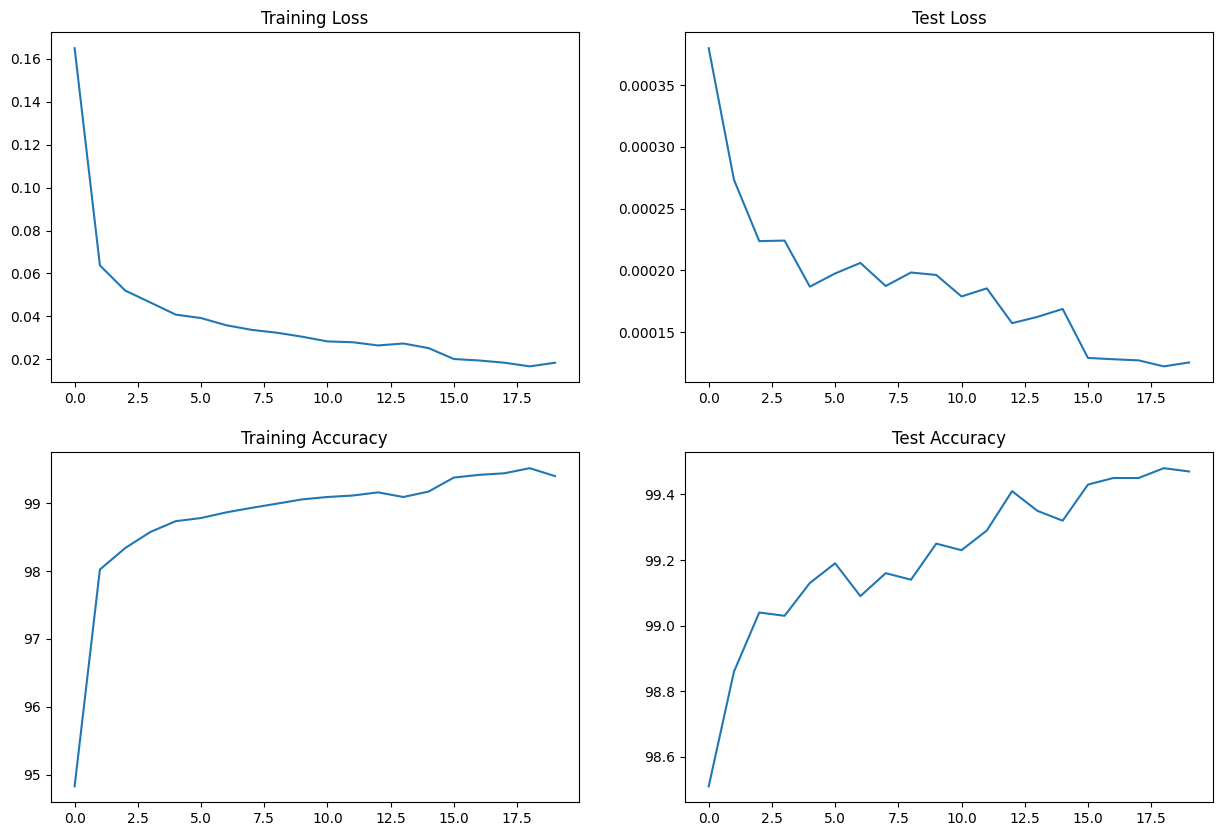

In [58]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")